# Deepfake Image Classification with PyTorch

This notebook demonstrates a full workflow for classifying deepfake images using a convolutional neural network (CNN) in PyTorch. The steps include data exploration, preprocessing, model building, training, and evaluation, with visualizations and clear explanations throughout.


## Importing libraries needed throughout the process

In [9]:
# Standard libraries
import os
from pathlib import Path

# Data handling and image processing
import numpy as np
from PIL import Image

# PyTorch and TorchVision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid

# Evaluation and model metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc,
    ConfusionMatrixDisplay
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Interface
import gradio as gr


## Preprocessing


### Visualize a Sample Image
Display a sample image from the dataset to verify image loading and format.

In [ ]:

# Display a sample image to verify loading
def show_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

show_image("FF++/Fake/000_003/001_0.tiff")

### Explore Dataset Structure

In [ ]:
def explore_dataset(root_dir):
    root = Path(root_dir)
    for category in root.iterdir():
        print(f"[{category.name}]")
        for person_folder in category.iterdir():
            print(f"  - {person_folder.name}: {len(list(person_folder.glob('*.tiff')))} images")
explore_dataset("FF++")


### Prepare the Dataset List

We create a list of image file paths along with their corresponding labels to be used for training and evaluation.
The key idea is to split the dataset **by subject**, ensuring that each person appears only in the **training** or **testing** set, but not both. This avoids data leakage and ensures a more realistic evaluation of model performance.


In [4]:
real_root = Path("FF++/Real")
fake_root = Path("FF++/Fake")
#preparing the real folder
#get folder names for real folder
real_folders = sorted([f.name for f in real_root.iterdir() if f.is_dir()])
train_ids, test_ids = train_test_split(real_folders, test_size=0.2, random_state=42) #split the folders for testing and training

train_real_images = []
test_real_images = []
#prepare the tuple of (imgURL,label)
for folder in train_ids:
    for img in (real_root / folder).glob("*.tiff"):
        train_real_images.append((str(img), 0))

for folder in test_ids:
    for img in (real_root / folder).glob("*.tiff"):
        test_real_images.append((str(img), 0))

#preparing the fake folder
train_fake_images = []
test_fake_images = []

for fake_folder in fake_root.iterdir():
    if not fake_folder.is_dir():
        continue

    #for example 001_870 becomes 001 to match the real folder
    real_id = fake_folder.name.split('_')[0]
    
    # use the previous list of ids for testing and training to prepare or fake images to have the same split and content of persons
    if real_id in train_ids:
        for img in fake_folder.glob("*.tiff"):
            train_fake_images.append((str(img), 1))
    elif real_id in test_ids:
        for img in fake_folder.glob("*.tiff"):
            test_fake_images.append((str(img), 1))

train_data = train_real_images + train_fake_images
test_data = test_real_images + test_fake_images

print(f'train data : {train_data[:5]}')



train data : [('FF++\\Real\\055\\000_0.tiff', 0), ('FF++\\Real\\055\\001_0.tiff', 0), ('FF++\\Real\\055\\002_0.tiff', 0), ('FF++\\Real\\055\\003_0.tiff', 0), ('FF++\\Real\\055\\004_0.tiff', 0)]


note : we could've used the `load_dataset` from `datasets` but each dataset would be {'image': {'path': '/path/to/image.jpg', 'bytes': None}, 'label': 1} which is very long 

### Implement Lazy Loading for Efficient Memory Usage

Use PyTorch's `Dataset` class to load images on-the-fly during training or evaluation, reducing memory usage. This approach avoids loading all images into memory at once.
basic approach of loading all in the memory will consume huge resources and slow the process

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

class LazyDataset(Dataset):
    def __init__(self, data_list, transform):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        path, label = self.data_list[idx]
        img = Image.open(path).convert('RGB')
        img = self.transform(img)
        return img, label



In [ ]:

train_dataset = LazyDataset(train_data, transform)
# print(train_dataset)
test_dataset = LazyDataset(test_data, transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True) #turned to true because the ways the data is loaded it needs to be shuffled



### Visualize a Batch of Images
Display a batch of images from the DataLoader to verify preprocessing and data augmentation steps.

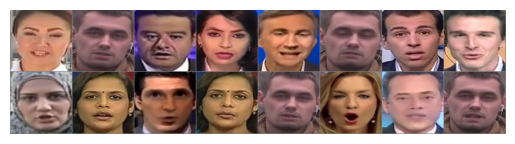

In [ ]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(make_grid(images))

## Training: Simple CNN Model vs. MobileNetV2 (from scratch)

We compare two convolutional neural network architectures trained from scratch on the same dataset:

- A custom-built simple CNN model.
- A MobileNetV2 model initialized without pretrained weights.

Both models are trained for **one epoch only** in order to:
- Benchmark their **initial accuracy** on the test set.
- Measure and compare their **training time**.

This quick comparison provides insights into their relative performance and computational cost in a minimal training scenario.


### Define the CNN Model
Build a basic convolutional neural network (CNN) architecture for image classification using PyTorch.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)  ## only 2 outputs in here since it's between real and fake 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

### Training Loop and Visualization
Run the training loop and visualize loss and AUC metrics for each epoch and batch.

In [ ]:


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

#### Batch-Level CNN Training
Monitor and log loss, accuracy, and AUC for every mini-batch set by log-steps during training.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

cnn_losses = []
cnn_accuracies = []
cnn_auc_scores = []
log_steps = 50  #every 16*50 set we log the auc loss and the accuracy
epochs_count = 1

for epoch in range(epochs_count):
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_scores = []
    all_labels = []

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, pred_cls = torch.max(outputs, 1)
        correct_train += (pred_cls == labels).sum().item()
        total_train += labels.size(0)

        all_scores.append(outputs[:, 1].detach().cpu())
        all_labels.append(labels.detach().cpu())

        running_loss += loss.item()

        if i % log_steps == log_steps - 1:
            avg_loss = running_loss / log_steps
            cnn_losses.append(avg_loss)
            current_accuracy = 100 * correct_train / total_train
            cnn_accuracies.append(current_accuracy)
            partial_scores = torch.cat(all_scores)
            partial_labels = torch.cat(all_labels)
            partial_auc = roc_auc_score(partial_labels.numpy(), partial_scores.numpy())

            print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}, accuracy: {current_accuracy:.2f}%, AUC: {partial_auc:.4f}')
            cnn_auc_scores.append(partial_auc)

            running_loss = 0.0
            correct_train = 0
            total_train = 0
            all_scores = []
            all_labels = []

    print(f'Epoch {epoch + 1} done.\n')

print('Finished Training')
torch.save(net.state_dict(), "fake_image_model.pth")


### Training with a mobilenet_v2 model

In [ ]:
import torchvision.models as models
import torch.nn as nn


# Load MobileNetV2 with no pretrained weights
mobilenet = models.mobilenet_v2(weights=None)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=1e-4)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 1)

mobilenet = mobilenet.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(mobilenet.parameters(), lr=0.001)

mobilenet.train()

mobilNet_losses = []
mobilNet_accuracies = []
mobilNet_auc_scores = []
log_steps = 50  # Every 50 batches
epochs_count = 1 # number of epoches

for epoch in range(epochs_count):  # loop over the dataset multiple times
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    all_scores = []
    all_labels = []

    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.float().unsqueeze(1).to(device)  # Shape: [batch_size, 1]

        optimizer.zero_grad()
        outputs = mobilenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        pred_cls = (torch.sigmoid(outputs) > 0.5).float()
        correct_train += (pred_cls == labels).sum().item()
        total_train += labels.size(0)

        all_scores.append(outputs.detach().cpu().squeeze())  
        all_labels.append(labels.detach().cpu())

        running_loss += loss.item()

        if i % log_steps == log_steps - 1:
            avg_loss = running_loss / log_steps
            mobilNet_losses.append(avg_loss)
            current_accuracy = 100 * correct_train / total_train
            mobilNet_accuracies.append(current_accuracy)
            partial_scores = torch.cat(all_scores)
            partial_labels = torch.cat(all_labels)
            partial_auc = roc_auc_score(partial_labels.numpy(), partial_scores.numpy())

            print(f'[{epoch + 1}, {i + 1:5d}] loss: {avg_loss:.3f}, accuracy: {current_accuracy:.2f}%, AUC: {partial_auc:.4f}')

            mobilNet_auc_scores.append(partial_auc)

            running_loss = 0.0
            correct_train = 0
            total_train = 0
            all_scores = []
            all_labels = []

    print(f'Epoch {epoch + 1} done.\n')

print('Finished Training')
torch.save(mobilenet.state_dict(), "fake_image_model_mobilenetCPU.pth")


### Visualization of the Models

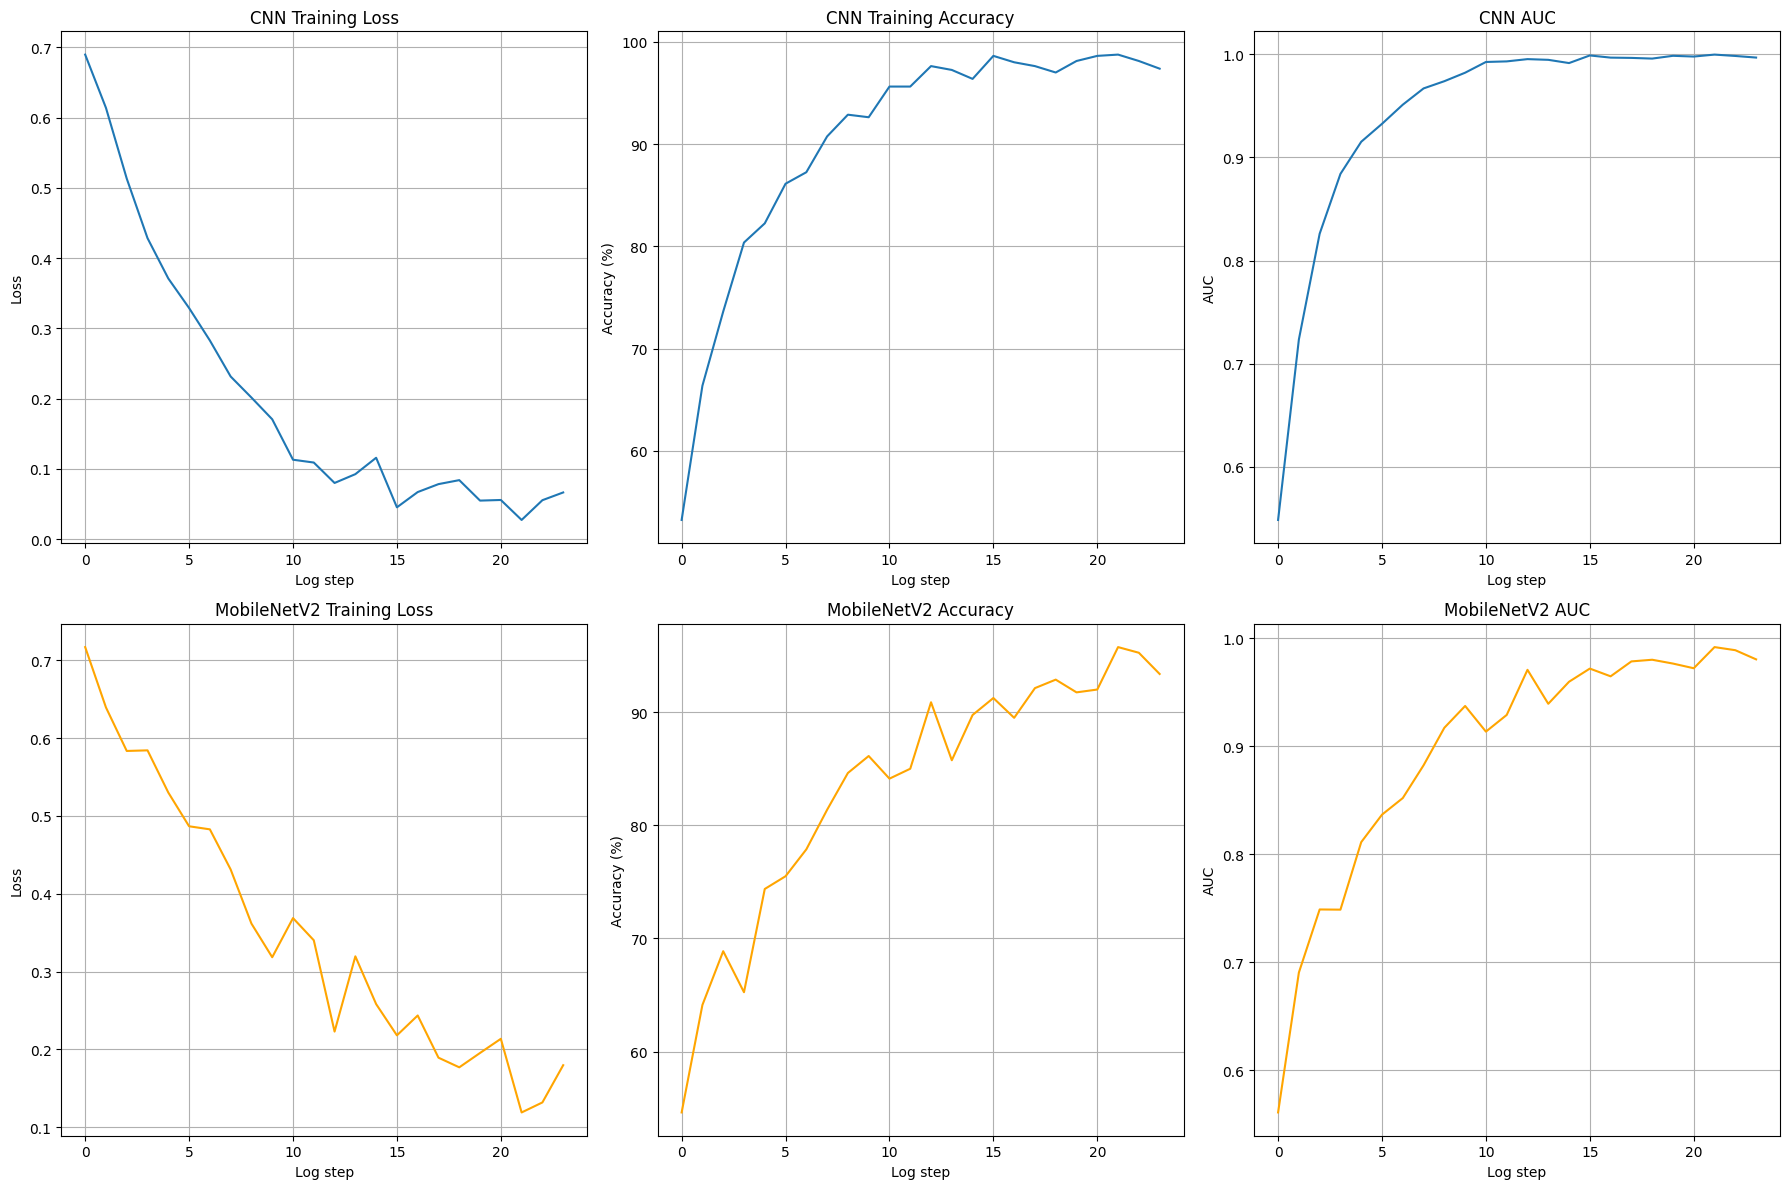

In [ ]:


steps = range(len(cnn_losses))

plt.figure(figsize=(18, 12))

#  CNN Model 
plt.subplot(2, 3, 1)
plt.plot(steps, cnn_losses, label="CNN Loss")
plt.title("CNN Training Loss")
plt.xlabel("Log step")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 3, 2)
plt.plot(steps, cnn_accuracies, label="CNN Accuracy")
plt.title("CNN Training Accuracy")
plt.xlabel("Log step")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.subplot(2, 3, 3)
plt.plot(steps, cnn_auc_scores, label="CNN AUC")
plt.title("CNN AUC")
plt.xlabel("Log step")
plt.ylabel("AUC")
plt.grid(True)

#  MobileNet 
steps = range(len(mobilNet_losses))

plt.subplot(2, 3, 4)
plt.plot(steps, mobilNet_losses, label="MobileNet Loss", color='orange')
plt.title("MobileNetV2 Training Loss")
plt.xlabel("Log step")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(2, 3, 5)
plt.plot(steps, mobilNet_accuracies, label="MobileNet Accuracy", color='orange')
plt.title("MobileNetV2 Accuracy")
plt.xlabel("Log step")
plt.ylabel("Accuracy (%)")
plt.grid(True)

plt.subplot(2, 3, 6)
plt.plot(steps, mobilNet_auc_scores, label="MobileNet AUC", color='orange')
plt.title("MobileNetV2 AUC")
plt.xlabel("Log step")
plt.ylabel("AUC")
plt.grid(True)

plt.tight_layout()
plt.show()

### Testing and Visualization
Evaluate the trained model on the test set and visualize the results.

#### Test Metrics per mini-batches

In [ ]:
import torch
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc , ConfusionMatrixDisplay
import plotly.graph_objects as go
import seaborn as sns


# Load model
device = torch.device("cpu")
net.load_state_dict(torch.load("fake_image_model.pth", map_location=device))
net = net.to(device)
net.eval()
criterion = torch.nn.CrossEntropyLoss()

# Logging and tracking
log_steps = 5
test_losses = []
test_accuracies = []
test_auc_scores = []

running_loss = 0.0
correct_test = 0
total_test = 0
all_scores = []
all_labels = []
all_preds = []  # predicted class labels
all_true = []   # true labels

with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = net(inputs)
        loss = criterion(outputs, labels)

        _, pred_cls = torch.max(outputs, 1)

        correct_test += (pred_cls == labels).sum().item()
        total_test += labels.size(0)

        all_scores.append(outputs[:, 1].detach().cpu())
        all_labels.append(labels.detach().cpu())
        all_preds.extend(pred_cls.cpu().numpy())
        all_true.extend(labels.cpu().numpy())

        running_loss += loss.item()

        if (i + 1) % log_steps == 0:
            avg_loss = running_loss / log_steps
            current_accuracy = 100 * correct_test / total_test
            partial_scores = torch.cat(all_scores)
            partial_labels = torch.cat(all_labels)
            partial_auc = roc_auc_score(partial_labels.numpy(), partial_scores.numpy())

            test_losses.append(avg_loss)
            test_accuracies.append(current_accuracy)
            test_auc_scores.append(partial_auc)

            print(f'Test batches [{i + 1 - log_steps + 1}–{i + 1}]: '
                  f'Loss: {avg_loss:.4f}, Accuracy: {current_accuracy:.2f}%, AUC: {partial_auc:.4f}')

            running_loss = 0.0
            correct_test = 0
            total_test = 0
            all_scores = []
            all_labels = []

print('Finished Testing CNN')
cm = confusion_matrix(all_true, all_preds)
# confusion matrix with Plotly

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


In [ ]:
import torch
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc , ConfusionMatrixDisplay
import plotly.graph_objects as go
import seaborn as sns


# --- MobileNet Testing ---
device_mobilenet = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mobilenet = models.mobilenet_v2(weights=None)
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 1)

mobilenet.load_state_dict(torch.load("fake_image_model_mobilenetCPU.pth", map_location=device_mobilenet))
mobilenet = mobilenet.to(device_mobilenet)
mobilenet.eval()

criterion_mobilenet = nn.BCEWithLogitsLoss()

log_steps_mobilenet = 5
test_losses_mobilenet = []
test_accuracies_mobilenet = []
test_auc_scores_mobilenet = []

running_loss_mobilenet = 0.0
correct_test_mobilenet = 0
total_test_mobilenet = 0
all_scores_mobilenet = []
all_labels_mobilenet = []

all_preds_mobilenet = []  # predicted class labels
all_true_mobilenet = []   # true labels
with torch.no_grad():
    for i, data in enumerate(test_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device_mobilenet)
        labels = labels.float().unsqueeze(1).to(device_mobilenet)

        outputs = mobilenet(inputs)
        loss = criterion_mobilenet(outputs, labels)

        probs = torch.sigmoid(outputs)
        pred_cls = (probs > 0.5).float()

        correct_test_mobilenet += (pred_cls == labels).sum().item()
        total_test_mobilenet += labels.size(0)

        all_scores_mobilenet.append(outputs.detach().cpu().squeeze())
        all_labels_mobilenet.append(labels.detach().cpu())
        all_preds_mobilenet.extend(pred_cls.cpu().numpy())
        all_true_mobilenet.extend(labels.cpu().numpy())


        running_loss_mobilenet += loss.item()

        if (i + 1) % log_steps_mobilenet == 0:
            avg_loss = running_loss_mobilenet / log_steps_mobilenet
            current_accuracy = 100 * correct_test_mobilenet / total_test_mobilenet
            partial_scores = torch.cat(all_scores_mobilenet)
            partial_labels = torch.cat(all_labels_mobilenet)
            partial_auc = roc_auc_score(partial_labels.numpy(), partial_scores.numpy())

            test_losses_mobilenet.append(avg_loss)
            test_accuracies_mobilenet.append(current_accuracy)
            test_auc_scores_mobilenet.append(partial_auc)

            print(f'MobileNet Test batches [{i + 1 - log_steps_mobilenet + 1}–{i + 1}]: '
                  f'Loss: {avg_loss:.4f}, Accuracy: {current_accuracy:.2f}%, AUC: {partial_auc:.4f}')

            running_loss_mobilenet = 0.0
            correct_test_mobilenet = 0
            total_test_mobilenet = 0
            all_scores_mobilenet = []
            all_labels_mobilenet = []

print('Finished Testing MobileNet')


cm = confusion_matrix(all_true_mobilenet, all_preds_mobilenet)
# confusion matrix with Plotly
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()




In [ ]:


epochs_mobilenet = range(1, len(test_losses_mobilenet) + 1)
epochs_cnn = range(1, len(test_losses) + 1)

plt.figure(figsize=(18, 5))

# Plot Loss
plt.subplot(1, 3, 1)
plt.plot(epochs_mobilenet, test_losses_mobilenet, label='MobileNet Loss', marker='o')
plt.plot(epochs_cnn, test_losses, label='CNN Loss', marker='o')
plt.title('Test Loss')
plt.xlabel('Log Step')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot Accuracy
plt.subplot(1, 3, 2)
plt.plot(epochs_mobilenet, test_accuracies_mobilenet, label='MobileNet Accuracy', marker='o')
plt.plot(epochs_cnn, test_accuracies, label='CNN Accuracy', marker='o')
plt.title('Test Accuracy')
plt.xlabel('Log Step')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# Plot AUC
plt.subplot(1, 3, 3)
plt.plot(epochs_mobilenet, test_auc_scores_mobilenet, label='MobileNet AUC', marker='o')
plt.plot(epochs_cnn, test_auc_scores, label='CNN AUC', marker='o')
plt.title('Test AUC Score')
plt.xlabel('Log Step')
plt.ylabel('AUC')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Interface for single image testing 
using gradio for a GUI to test the outputs of the CNN model

In [ ]:
# Load model
net = Net()
net.load_state_dict(torch.load("fake_image_model.pth", map_location="cpu"))

net.eval()


# Define transform and predict function
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Optional but often helpful
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

def predict(img):
    img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        outputs = net(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)[0]  # Get first sample's output

    fake_prob = probabilities[1].item()  # Assuming class index 1 = "Fake"
    real_prob = probabilities[0].item()
    return {"Fake": fake_prob, "Real": real_prob}


# Gradio Interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=2),
    title="Fake Image Detector",
    description="Upload an image to detect if it's fake or real."
)

demo.launch()